Кулаков Ярослав Михайлович BCI.

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.cross_decomposition import PLSRegression
from IPython.display import clear_output
import imageio
import os
import matplotlib
import time 
from sklearn.linear_model import LinearRegression

Загрузка датасета.

In [2]:
X_train = scipy.io.loadmat('ECoG_data/ECoG_X_train.mat')
X_train = X_train['X_train']
X_train.shape

(12801, 32, 27)

In [3]:
X_test = scipy.io.loadmat('ECoG_data/ECoG_X_test.mat')
X_test = X_test['X_hold_out']
X_test.shape

(6087, 32, 27)

In [4]:
y_train = scipy.io.loadmat('ECoG_data/ECoG_Y_train.mat')
y_train = y_train['Y_train']
y_train.shape

(12801, 3)

In [5]:
y_test = scipy.io.loadmat('ECoG_data/ECoG_Y_test.mat')
y_test = y_test['Y_hold_out']
y_test.shape

(6087, 3)

Протестируем на нескольких рядах алгоритм SARIMAX. Сгенерируем 3 функции.

In [6]:
def linear_part(x):
    return (x/70)**2 + np.sin(x/3.2) + 3*np.sin(x/7.3) +  np.exp(-0.07*(x-50)**2 )*10 + random()/8

def spire_part(x):
    return (x/70)**2 + np.sin(x/3.2) + 3*np.sin(x/7.3) +  np.exp(-0.07*(x-98)**2 )*10 + random()/4

def noize_part(x):
    return (x/70)**2 + np.sin(x/3.2) + 3*np.sin(x/7.3) +  np.exp(-0.07*(x-50)**2 )*10 + random()*(x**0.7)/10

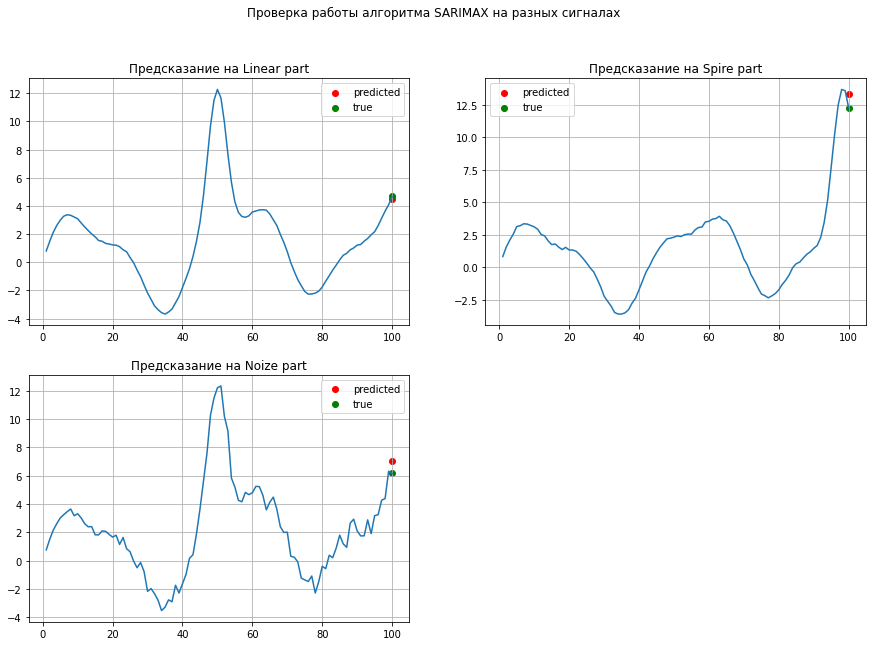

In [7]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset

functions = [linear_part , spire_part, noize_part]
names = ['Linear part', 'Spire part', 'Noize part']


plt.figure(figsize=(15,10))
plt.suptitle("Проверка работы алгоритма SARIMAX на разных сигналах")
for i in range(3):
    data = [functions[i](x) for x in range(1, 100)]
    y_true = functions[i](100)


    # fit model
    model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.predict(len(data), len(data))

    plt.subplot(2,2,i+1)
    plt.title("Предсказание на " + names[i])
    plt.plot(range(1, 101), data + [y_true])
    plt.scatter([100], [yhat], color='r', label='predicted')
    plt.scatter([100], [y_true], color='g', label='true')
    plt.legend()
    plt.grid()
plt.show()

Можно сделать вывод, что на плавных, близких к линейным участкам сигнала, предсказание алгоритма почти идеальное. Другое дело --- в области резкого изменения сигнала алгоритм справляется не оченьь хорошо. Так же при сильном шуме предсказания получаюся слабыми.

Посмотрим как будет предсказываться координата этим алгоритмом только по прошлым значениям координаты.

In [8]:
predicted_coords = []
for i in range(100,400):
    data = y_train[:i, 0]
    model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit(disp=False)
    # make prediction
    predicted_coords.append(model_fit.predict(len(data), len(data)))

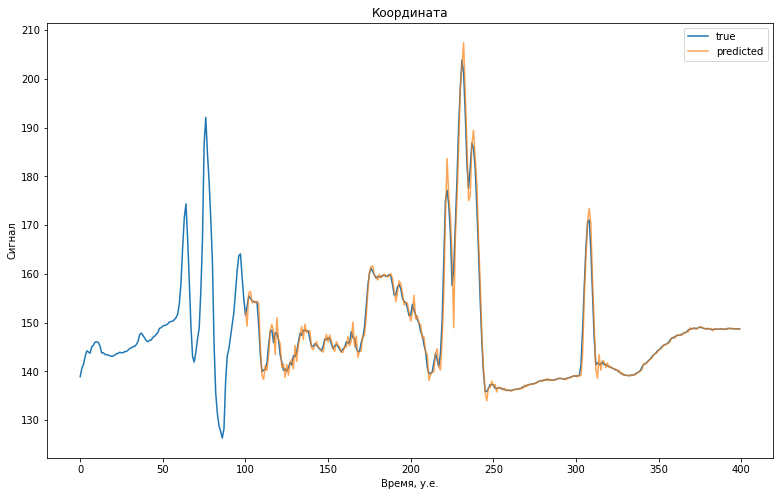

In [9]:
plt.figure(figsize=(13,8))
plt.title("Координата")
plt.plot(np.arange(400), y_train[:400, 0], label='true')
plt.plot(range(100,400), predicted_coords, label='predicted', alpha=0.7)
plt.xlabel("Время, у.е.")
plt.ylabel("Сигнал")
plt.legend()
plt.show()

Обучим PLS. Сгенерируем признаки : экспоненциируем все данные.

In [10]:
pls2 = PLSRegression(n_components=20, max_iter=20000).fit(np.hstack((X_train[:,:, :].reshape((12801, -1)), np.exp(X_train[:,:, :].reshape((12801, -1))))),y_train)

In [11]:
Y_pred = pls2.predict(np.hstack((X_train[:,:, :].reshape((12801, -1)), np.exp(X_train[:,:, :].reshape((12801, -1))))))

In [12]:
def smooth(x, k):
    """
    Для ряда считает среднее по окну длиной к.
    """
    return (np.cumsum(x)[k-1:]  -  np.append([0],np.cumsum(x)[:-k]))/k

In [13]:
ft = [1000, 2000] # верменной диапазон для отрисовки.
k = 7 # размер окна сглаживания

In [14]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

Предскажем координатц по ее прошлым значениям.

In [15]:
predicted_coords = []
ft = [1000, 1500] # верменной диапазон для отрисовки.

for i in tqdm(range(ft[0],ft[1])):
    data = y_train[ft[0]-100:i, 0]
    model = SARIMAX(data, order=(5, 1, 1), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit(disp=False)
    # make prediction
    predicted_coords.append(model_fit.predict(i, i))

  1%|▏         | 7/500 [00:00<00:57,  8.53it/s]/home/yaroslaw/anaconda3/envs/mipt-stats/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|██████████| 500/500 [01:22<00:00,  6.07it/s]


In [16]:
len(predicted_coords)

500

In [17]:
predicted_coords = np.array(predicted_coords)

In [18]:
errors = pd.DataFrame(columns=['MSE', 'MAE'])

Построим графики для разных предсказаний.

__X -> Y, ECoG__

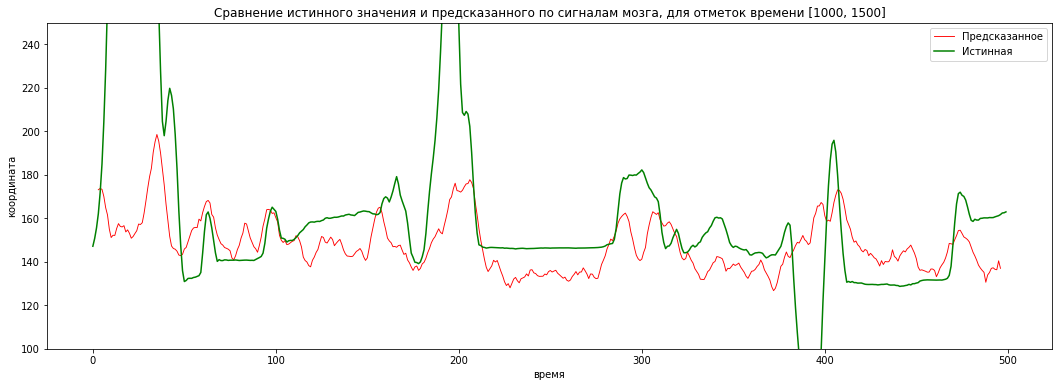

In [19]:
for coord in range(1):
    plt.figure(figsize=(18,6))
    plt.title("Сравнение истинного значения и предсказанного по сигналам мозга, для отметок времени [%d, %d]" % ( ft[0], ft[1]))
    plt.plot(np.arange(k//2,(ft[1]-ft[0]) - k//2), smooth(Y_pred[ft[0]:ft[1],coord], k), c='r', lw=0.9, label="Предсказанное")
    plt.plot(np.arange(ft[1]-ft[0]), y_train[ft[0]:ft[1],coord], c='g', label="Истинная")
    plt.xlabel("время")
    plt.ylabel("координата")
    plt.legend()
    plt.ylim([100, 250])
    plt.savefig('1.png')
    plt.show()

In [20]:
errors.loc['Clear PLS', 'MSE'] = mean_squared_error(Y_pred[ft[0] + 50:ft[1],0], y_train[ft[0] + 50:ft[1],0])
errors.loc['Clear PLS', 'MAE'] = mean_absolute_error(Y_pred[ft[0] + 50:ft[1],0], y_train[ft[0] + 50:ft[1],0])

__Y -> Y, SARIMAX__

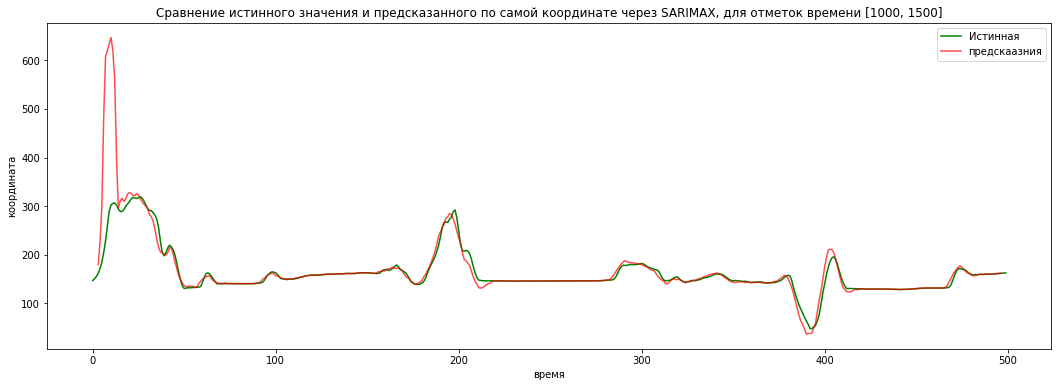

In [21]:
for coord in range(1):
    plt.figure(figsize=(18,6))
    plt.title("Сравнение истинного значения и предсказанного по самой координате через SARIMAX, для отметок времени [%d, %d]" % (ft[0], ft[1]))
    plt.plot(np.arange(ft[1]-ft[0]), y_train[ft[0]:ft[1],coord], c='g', label="Истинная")
    plt.plot(np.arange(k//2,(ft[1]-ft[0]) - k//2), smooth(predicted_coords.T[0], k) , label="предскаазния", c='r', alpha=0.7)
    plt.xlabel("время")
    plt.ylabel("координата")
    plt.legend()
    plt.savefig('2.png')

    plt.show()

In [22]:
errors.loc['Clear SARIMAX(5)', 'MSE'] = mean_squared_error(predicted_coords.T[0][50:], y_train[ft[0] + 50:ft[1],0])
errors.loc['Clear SARIMAX(5)', 'MAE'] = mean_absolute_error(predicted_coords.T[0][50:], y_train[ft[0] + 50:ft[1],0])

__X, Y -> Y, BLEND(SARIMAX, PLS)__

FInd Best Alpha

In [23]:
alpha_space = np.linspace(0,1,20)
mse_min = np.inf
mae_min = np.inf
alhpa_mse = 0
alpha_mae=0
mse, mae = [], []
for alpha in alpha_space:
    mse.append(mean_squared_error(alpha*predicted_coords.T[0][50:] + (1-alpha)*Y_pred[ft[0] + 50:ft[1], 0], y_train[ft[0] + 50:ft[1],0]))
    mae.append(mean_absolute_error(alpha*predicted_coords.T[0][50:] + (1-alpha)*Y_pred[ft[0] + 50:ft[1], 0], y_train[ft[0] + 50:ft[1],0]))
    if mse[-1] < mse_min:
        mse_min = mse[-1]
        alpha_mse = alpha
    if mae[-1] < mae_min:
        mae_min = mae[-1]
        alpha_mae = alpha

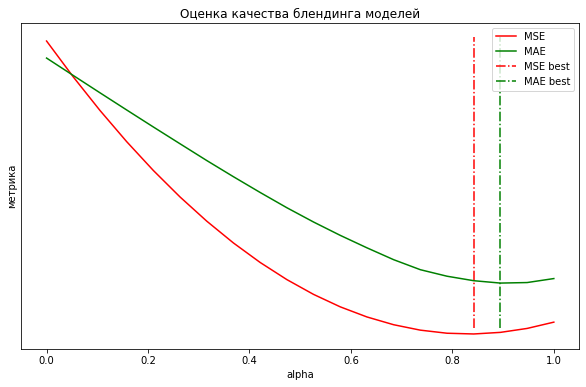

0.8421052631578947 0.894736842105263


In [24]:
plt.figure(figsize=(10,6))
plt.title('Оценка качества блендинга моделей')
plt.plot(alpha_space, mse, label='MSE', color='red')
plt.plot(alpha_space, 40*np.array(mae), label='MAE', color='green')
plt.vlines(alpha_mse,100,800, label='MSE best', color='red',linestyle='-.')
plt.vlines(alpha_mae,100,800, label='MAE best', color='green', linestyle='-.')

plt.yticks([])
plt.legend()
#plt.ylim([100,820])
plt.xlabel('alpha')
plt.ylabel('метрика')
plt.savefig('5.png')
plt.show()


print(alpha_mse, alpha_mae)

In [25]:
alpha = np.mean([alpha_mse, alpha_mae])
alpha

0.8684210526315789

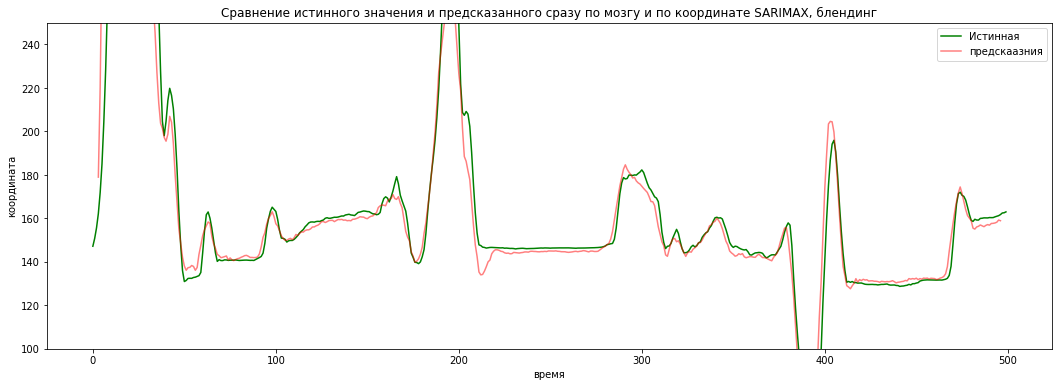

In [27]:
for coord in range(1):
    plt.figure(figsize=(18,6))
    plt.title("Сравнение истинного значения и предсказанного сразу по мозгу и по координате SARIMAX, блендинг")
    plt.plot(np.arange(ft[1]-ft[0]), y_train[ft[0]:ft[1],coord], c='g', label="Истинная")
    plt.plot(np.arange(k//2,(ft[1]-ft[0]) - k//2), alpha*smooth(predicted_coords.T[0], k) + (1-alpha)*smooth(Y_pred[ft[0]:ft[1],coord], k), label="предскаазния", c='r', alpha=0.5)
    plt.xlabel("время")
    plt.ylabel("координата")
    plt.legend()
    plt.ylim([100, 250])
    plt.savefig('3.png')

    plt.show()

In [28]:
errors.loc['Mix_pls_sarimax', 'MSE'] = mean_squared_error(alpha*predicted_coords.T[0][50:] + (1-alpha)*Y_pred[ft[0] + 50:ft[1], 0], y_train[ft[0] + 50:ft[1],0])
errors.loc['Mix_pls_sarimax', 'MAE'] = mean_absolute_error(alpha*predicted_coords.T[0][50:] + (1-alpha)*Y_pred[ft[0] + 50:ft[1], 0], y_train[ft[0] + 50:ft[1],0])

__Y -> Y, AutoRegression__

In [29]:
y_reg_train = y_train[:400,0].reshape(-1,1) #  обучение на первых 400 точках

X_reg_train = np.hstack((y_reg_train[:-5], y_reg_train[1:-4], y_reg_train[2:-3], y_reg_train[3:-2], y_reg_train[4:-1], y_reg_train[5:]))[:-1]
X_reg_train.shape

Y_reg_train = y_reg_train[6:]
Y_reg_train.shape

y_test_reg = y_train[:2000,0].reshape(-1,1) # предсказание на первых 2000 точках

X_test_reg = np.hstack((y_test_reg[:-5], y_test_reg[1:-4], y_test_reg[2:-3], y_test_reg[3:-2], y_test_reg[4:-1], y_test_reg[5:]))[:-1]
X_test_reg.shape

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

reg = LinearRegression(fit_intercept=False)
reg.fit(X_reg_train,Y_reg_train)
y_reg_pred = reg.predict(X_test_reg)
y_reg_pred.shape

y_reg_pred[ft[0]:ft[1]-6][:,0].shape, y_train[ft[0]+6:ft[1], 0].shape  # проверка что сошлись размерности

((494,), (494,))

In [30]:
errors.loc['Clear AR', 'MSE'] = mean_squared_error(y_reg_pred[ft[0]:ft[1]-6][:,0][50:], y_train[ft[0] + 56:ft[1],0])
errors.loc['Clear AR', 'MAE'] = mean_absolute_error(y_reg_pred[ft[0]:ft[1]-6][:,0][50:], y_train[ft[0] + 56:ft[1],0])

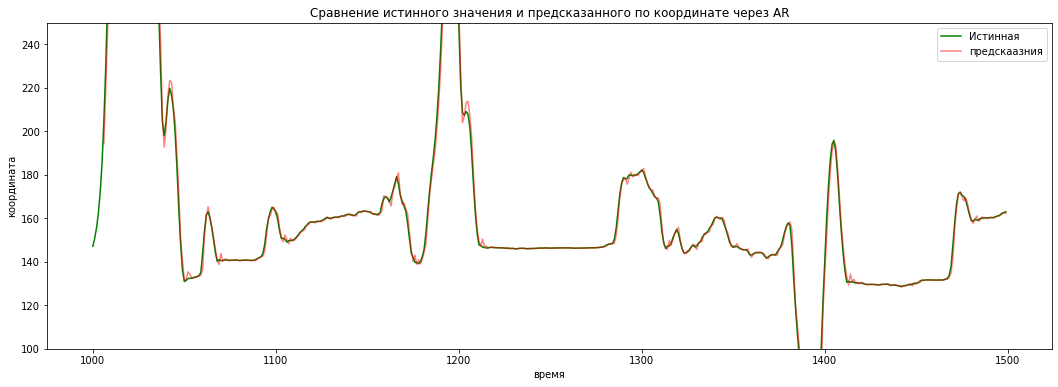

In [31]:
for coord in range(1):
    plt.figure(figsize=(18,6))
    plt.title("Сравнение истинного значения и предсказанного по координате через AR")
    plt.plot(np.arange(ft[0], ft[1]), y_train[ft[0]:ft[1],coord], c='g', label="Истинная")
    plt.plot(np.arange(ft[0]+6,ft[1]), y_reg_pred[ft[0]:ft[1]-6][:,0], label="предскаазния", c='r', alpha=0.5)

    plt.xlabel("время")
    plt.ylabel("координата")
    plt.legend()
    plt.ylim([100, 250])
    plt.savefig('4.png')

    plt.show()

__X, Y -> Y, Blending(PLS, AR)__

Find Best Alpha

In [32]:
alpha_space = np.linspace(0,1,20)
mse_min = np.inf
mae_min = np.inf
alhpa_mse = 0
alpha_mae=0
mse, mae = [], []
for alpha in alpha_space:
    mse.append(mean_squared_error(alpha*y_reg_pred[ft[0]:ft[1]-6][:,0][50:] + (1-alpha)*Y_pred[ft[0] + 56:ft[1], 0], y_train[ft[0] + 56:ft[1],0]))
    mae.append(mean_absolute_error(alpha*y_reg_pred[ft[0]:ft[1]-6][:,0][50:] + (1-alpha)*Y_pred[ft[0] + 56:ft[1], 0], y_train[ft[0] + 56:ft[1],0]))
    if mse[-1] < mse_min:
        mse_min = mse[-1]
        alpha_mse = alpha
    if mae[-1] < mae_min:
        mae_min = mae[-1]
        alpha_mae = alpha

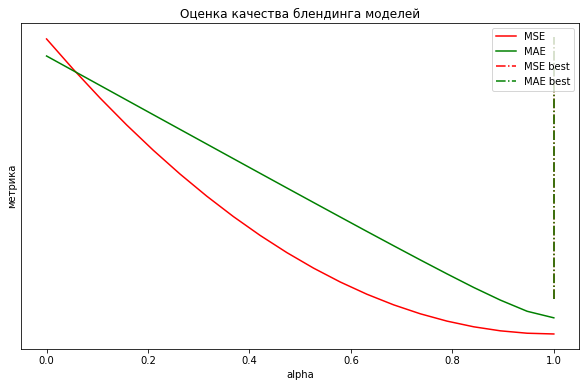

1.0 1.0


In [33]:
plt.figure(figsize=(10,6))
plt.title('Оценка качества блендинга моделей')
plt.plot(alpha_space, mse, label='MSE', color='red')
plt.plot(alpha_space, 40*np.array(mae), label='MAE', color='green')
plt.vlines(alpha_mse,100,800, label='MSE best', color='red',linestyle='-.')
plt.vlines(alpha_mae,100,800, label='MAE best', color='green', linestyle='-.')

plt.yticks([])
plt.legend()
#plt.ylim([100,820])
plt.xlabel('alpha')
plt.ylabel('метрика')
plt.savefig('6.png')
plt.show()


print(alpha_mse, alpha_mae)

In [34]:
alpha = np.mean([alpha_mse, alpha_mae])
alpha

1.0

In [35]:
errors.loc['Mix_pls_ar', 'MSE'] = mean_squared_error(alpha*y_reg_pred[ft[0]:ft[1]-6][:,0][50:] + (1-alpha)*Y_pred[ft[0] + 56:ft[1], 0], y_train[ft[0] + 56:ft[1],0])
errors.loc['Mix_pls_ar', 'MAE'] = mean_absolute_error(alpha*y_reg_pred[ft[0]:ft[1]-6][:,0][50:] + (1-alpha)*Y_pred[ft[0] + 56:ft[1], 0], y_train[ft[0] + 56:ft[1],0])

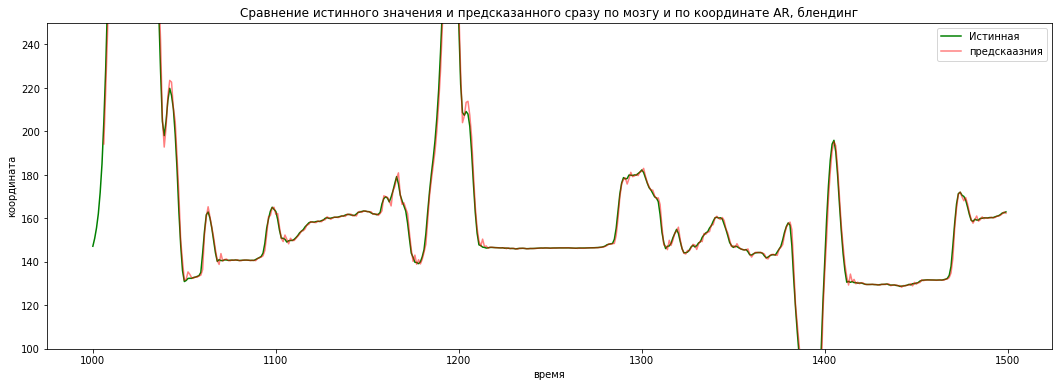

In [36]:
for coord in range(1):
    plt.figure(figsize=(18,6))
    plt.title("Сравнение истинного значения и предсказанного сразу по мозгу и по координате AR, блендинг")
    plt.plot(np.arange(ft[0], ft[1]), y_train[ft[0]:ft[1],coord], c='g', label="Истинная")
    plt.plot(np.arange(ft[0]+6,ft[1]),  alpha*y_reg_pred[ft[0]:ft[1]-6][:,0] + (1-alpha)* Y_pred[ft[0] +6:ft[1], 0], label="предскаазния", c='r', alpha=0.5)
    plt.xlabel("время")
    plt.ylabel("координата")
    plt.legend()
    plt.ylim([100, 250])
    plt.show()

In [37]:
errors

,MSE,MAE
Clear PLS,791.429,18.7611
Clear SARIMAX(5),115.063,5.49812
Mix_pls_sarimax,87.8215,5.28448
Clear AR,5.49391,1.21899
Mix_pls_ar,5.49391,1.21899
